# Data

In [ ]:
import io
import os
import re
import requests
import string
from tqdm import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
main_characters = ['CHANDLER', 'JOEY', 'MONICA', 'PHOEBE', 'ROSS', 'RACHEL']
url_base = 'https://www.drodd.com/friends'
SEASON_COUNT = 10
NEWLINE_REPLACEMENT = ' 5923 '

## Parse main url for getting links for all episodes

In [ ]:
r = requests.get(url_base)
soup = BeautifulSoup(r.content)
links_by_episode = [(i['href'][14:-4], url_base + "/" + i['href']) for i in soup.find_all('a') if str(i).find('name') == -1][1:-3]
links = []
for i, j in links_by_episode:
    if i == '212_213':
        links.append((2, 12, j))
    elif i == '615616':
        links.append((6, 15, j))
    elif i == '723.':
        links.append((7, 23, j))
    else:
        links.append((int(i) // 100, int(i) % 100, j))

# Links to every episode
links_by_episode = links # link to every episode

all_scripts = {i + 1: {} for i in range(SEASON_COUNT)}
scripts_with_context = {i + 1: {} for i in range(SEASON_COUNT)}

Transcript links with broken structure

In [ ]:
exception_episodes = [(1, 5),(2, 18),(6, 11),(7, 11),(7, 23), (9, 1), (9, 2), (9, 3), (9, 4), (9, 8)] + [(8, i) for i in range(7, 24)]

In [ ]:
# Iterate through each link by episode
for i in links_by_episode:
    # Initialize an empty dictionary for each episode within its respective season
    scripts_with_context[i[0]][i[1]] = {}
# Iterate through seasons, excluding the last one
for season in tqdm(range(1, SEASON_COUNT)):
    # Iterate through episode numbers within the current season
    for num in scripts_with_context[season].keys():
        # Skip episodes listed in the exception_episodes list
        if (season, num) in exception_episodes:
            continue

        # Iterate through each link by episode
        for i, j, k in links_by_episode:
            # Assign variables for link season, episode, and the link itself
            link_season = i
            link_episode = j
            lnk = k

            # Check if the current link corresponds to the current season and episode
            if season == link_season and num == link_episode:
                # Initialize an empty string to store the script
                current_script_with_context = ''

                # Make a GET request to fetch the script content from the link
                r = requests.get(lnk)

                # Parse the HTML content of the page using BeautifulSoup
                soup = BeautifulSoup(r.content)

                # Extract all <p> elements which usually contain the script content
                script_raw = soup.find_all('p')

                # Initialize the maximum script length
                max_script = script_raw[0]

                # Find the longest script element
                for i in script_raw:
                    if len(i) > len(max_script):
                        max_script = i

                # Clean and preprocess the script text
                # Convert the BeautifulSoup object max_script to a string and replace '<p>' tags with an empty string
                script = str(max_script).replace("<p>", "")
                # Replace '</p>' tags with an empty string in the script string
                script = script.replace("</p>", "")
                # Replace '<br/><br/>' tags with '\n' (newline) in the script string
                script = script.replace("<br/><br/>", "\n")
                # Replace '<br/>' tags with a space in the script string
                script = script.replace("<br/>", " ")
                # Replace '\r\n' (carriage return and newline) characters with an empty string in the script string
                script = script.replace('\r\n', '')
                # Use regular expressions to remove text within square brackets (e.g., [some text]) from the script string
                script = re.sub(r'\[(.*?)\]', '', script)
                # Use regular expressions to remove text within parentheses (e.g., (some text)) from the script string
                script = re.sub(r'\(.*?\)', '', script)
                # Use regular expressions to replace multiple spaces with a single space in the script string
                script = re.sub(' +', ' ', script)
                # Use regular expressions to replace multiple consecutive newline characters with a single newline character in the script string
                script = re.sub('\n+', '\n', script)
                # Use regular expressions to replace newline character followed by a space with just a newline character in the script string
                script = re.sub('\n ', '\n', script)
                # Use regular expressions to replace multiple consecutive newline characters with just a single newline character in the script string
                script = re.sub('\n\n+', '\n', script)

                # Split the script string into a list of lines using newline character ('\n') as the delimiter
                # Filter out lines that contain 'SCENE [0-9]+:' or 'SCENE:' using regular expressions
                script = [i for i in script.split('\n') if not(re.search('SCENE [0-9]+:|SCENE:', i))]

                # Filter out empty lines from the list of script lines
                script = [i for i in script if i != '']

                # Process each line of the script
                for line in script:
                    # Find the index of ':' in the line
                    idx = line.find(':')

                    # If ':' is found, extract the character name
                    if idx != -1:
                        cur_char = line[:idx].upper()
                        # Check if the character is one of the main_characters
                        if cur_char in main_characters:
                            current_script_with_context += line[:idx].upper() + line[idx:] + NEWLINE_REPLACEMENT
                        else:
                            current_script_with_context += "OTHER" + line[idx:] + NEWLINE_REPLACEMENT

                # Assign the processed script to the corresponding episode in scripts_with_context
                scripts_with_context[season][num] = current_script_with_context


100%|██████████| 9/9 [02:48<00:00, 18.74s/it]


In [ ]:
scripts_with_context[1][1]

"MONICA: There's nothing to tell! He's just some guy I work with!  5923 JOEY: C'mon, you're going out with the guy! There's gotta be something wrong with him!  5923 CHANDLER: So does he have a hump? A hump and a hairpiece?  5923 PHOEBE: Wait, does he eat chalk?  5923 PHOEBE: Just, 'cause, I don't want her to go through what I went through with Carl- oh!  5923 MONICA: Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.  5923 CHANDLER: Sounds like a date to me.  5923 CHANDLER: Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realise I am totally naked.  5923 OTHER: Oh, yeah. Had that dream.  5923 CHANDLER: Then I look down, and I realise there's a phone... there.  5923 JOEY: Instead of...?  5923 CHANDLER: That's right.  5923 JOEY: Never had that dream.  5923 PHOEBE: No.  5923 CHANDLER: All of a sudden, the phone starts to ring. And it turns out it's my mother, which is very weird, because- sh

Do the same for exceptional episodes

In [ ]:
# Iterate over each season and episode combination in the exception_episodes list,
# as well as additional episodes from links_by_episode if the season is 10 and the episode is not 15
for season, episode in tqdm(exception_episodes + [(l[0], l[1]) for l in links_by_episode if l[0] == 10 and l[1] != 15]):
    # Iterate over each link by episode
    for i, j, k in links_by_episode:
        # Extract season, episode, and link information
        link_season = i
        link_episode = j
        lnk = k

        # Check if the current link corresponds to the current season and episode
        if season == link_season and episode == link_episode:
            # Make a GET request to fetch the script content from the link
            r = requests.get(lnk)

            # Parse the HTML content of the page using BeautifulSoup
            soup = BeautifulSoup(r.content)

            # Extract all <p> elements which usually contain the script content
            script_raw = soup.find_all('p')

            # Remove unwanted header and footer lines from the script content
            script_raw = script_raw[3:-12]

            # Initialize variables to store the processed script
            script_res = ''
            current_script_with_context = ''

            # Iterate through each line of the script content
            for line in script_raw:
                # Skip lines with multiple <strong> tags, which usually indicate headers
                if len(line.find_all('strong')) > 1:
                    continue

                # Convert the line to a string and perform various replacements to clean it
                script = str(line)
                script = script.replace("<p>", "").replace("</p>", "").replace("<br/><br/>", "\n").replace("<br/>", " ")
                script = script.replace("<em>", "").replace("</em>", "")
                script = script.replace("<strong>", "").replace("</strong>", "").replace("{", "(")
                script = re.sub('\r\n', '', script)
                script = re.sub(r'\[(.*?)\]', '', script)
                script = re.sub(r'\(.*?\)', '', script)

                # Find the index of ':' in the line to identify the character speaking
                tag = script.find(":")
                if tag > -1:
                    # Extract the character name and the spoken dialogue
                    cur_char = script[:tag].upper()
                    script = script[tag+2:]
                    script = re.sub(' +', ' ', script)
                    script = re.sub('\n', '', script)
                    script = script.strip()

                    # Check if the character is one of the main_characters
                    if script != '':
                        if script.find(')') > -1:
                            continue
                        if cur_char in main_characters:
                            # Append the character's Russian name and the dialogue to the current_script_with_context
                            current_script_with_context += cur_char + ": " + script + NEWLINE_REPLACEMENT
                        else:
                            # Append "НЕДРУГ" (meaning "OTHER" in Russian) and the dialogue to the current_script_with_context
                            current_script_with_context += "OTHER: " + script + NEWLINE_REPLACEMENT

            # Assign the processed script to the corresponding episode in scripts_with_context
            scripts_with_context[season][episode] = current_script_with_context


100%|██████████| 43/43 [00:30<00:00,  1.42it/s]


# 2-18

In [ ]:
r = requests.get('https://www.drodd.com/friends/friend-episode218.htm')
soup = BeautifulSoup(r.content)
script_raw = soup.find_all('pre')[0]
script = str(script_raw).replace("<p>", "").replace("</p>", "").replace("<br/><br/>", "\n").replace("<br/>", " ").replace("<pre>", "").replace("</pre>", "")
script = script.replace("<em>", "").replace("</em>", "")
script = script.replace("<strong>", "").replace("</strong>", "").replace("{", "(")
script = re.sub('\r\n', '\n', script)
script = re.sub('\n +', '\n', script)
script = re.sub(r'\[(.*?)\]', '', script)
script = re.sub(r'\(.*?\)', '', script)
script = re.sub('\n\n', '\n', script)
script = re.sub('DELIVERY GUY', '\nDELIVERY GUY', script)

current_script_with_context = ''

for line in script.split('\n'):
    if line in ('', '\n') or line.find(']') > -1:
        continue
    if line.replace(" ", "").isupper():
        continue
    tag = line.find('[')
    if tag > - 1:
        current_script_with_context += line[:tag] + '\n'
    elif not(line[0].isupper() and line[1].isupper()):
        current_script_with_context = current_script_with_context[:-1] + " " + line
    else:
        current_script_with_context += line + '\n'
current_script_with_context = re.sub('\n\n', '\n', current_script_with_context)
current_script_with_context = re.sub('\n \n', '\n', current_script_with_context)
current_script_with_context = current_script_with_context.strip()


script = current_script_with_context.split('\n')
current_script_with_context = ''
for line in script:
    tag = line.find(':')
    cur_char = line[:tag]
    if cur_char in main_characters:
        current_script_with_context += cur_char + ": " + line[tag+2:] + NEWLINE_REPLACEMENT
    else:
        current_script_with_context += "OTHER: " + line[tag+2:] + NEWLINE_REPLACEMENT
scripts_with_context[2][18] = current_script_with_context

# 10-15

In [ ]:
exception = {'BOTH',
 'JANICE',
 'JENNIFER',
 'LADY',
 'MR ZELNER',
 'PHOEBE-ESTELLE',
 'REALTOR'}

lnk = 'https://www.drodd.com/friends/friend-episode1015.htm'
r = requests.get(lnk)
soup = BeautifulSoup(r.content)
script_raw = soup.find_all('p')
script_raw = script_raw[12:]
script = str(script_raw).replace("<p>", "").replace("</p>,", "\n").replace("</p>", "\n").replace("<br/><br/>", "\n").replace("<br/>", " ")
script = script.replace('\r\n', '')
script = str(re.sub(r'\(*[a-zA-Z\s,.;+\'\-]+\)', '', script))
script = script[1:-1]
script = re.sub('\n+', '\n', script)
script = re.sub('\n ', '\n', script)
script = re.sub('\n\n+', '\n', script)
script = [i for i in script.split('\n') if not(re.search('SCENE [0-9]+:|SCENE:', i))]
script = [i for i in script if i != '']
text = ""
last_char = ""
char_set = set()

current_script_with_context = ''
for line in script:
    if line in ('', '\n') or line.find(']') > -1:
        continue
    if line.replace(" ", "").isupper():
        continue
    if not(line[0].isupper() and line[1].islower()):
        current_script_with_context = current_script_with_context[:-1] + " " + line.strip() + '\n'
    else:
        current_script_with_context += line + '\n'
current_script_with_context = current_script_with_context.strip()

script = current_script_with_context.split('\n')
current_script_with_context = ''
for line in script:
    tag = line.find(':')
    cur_char = line[:tag].upper()
    if cur_char in main_characters:
        current_script_with_context += cur_char + ": " + line[tag+1:].strip() + NEWLINE_REPLACEMENT
    else:
        current_script_with_context += "OTHER: " + line[tag+2:] + NEWLINE_REPLACEMENT
scripts_with_context[10][15] = current_script_with_context

# 9-8


In [ ]:
r = requests.get(links_by_episode[195][2])
soup = BeautifulSoup(r.content)
script_raw = str(soup.find_all('article')[0]).replace('&gt;', '>')
script_raw = re.sub('<[^<]+>', "", script_raw)
script_raw = re.sub(r'\[(.*?)\]', '', script_raw)
script_raw = re.sub(r'\(.*?\)', '', script_raw)
text = script_raw.split('\n')
text = [x.strip() for x in text if x.strip() != '' and x.strip() != '\r']
text = text[5:-2]

current_script_with_context = ''

for line in text:
    if line in ('', '\n') or line.find(']') > -1 or line.lower().find('scene') > -1:
        continue
    if line.replace(" ", "").isupper():
        continue
    if not(line[0].isupper() and line[1].islower()) or line.find(':') == -1:
        current_script_with_context = current_script_with_context[:-1] + " " + line.strip() + '\n'
    else:
        current_script_with_context += line.strip() + '\n'

current_script_with_context = current_script_with_context.strip()
script_with_context = ''

for line in current_script_with_context.split('\n'):
    column_loc = line.find(':')
    ch_name = line[:column_loc].split()[0].upper()
    if ch_name in main_characters:
        ch_name = ch_name
    else:
        ch_name = "OTHER"
    script_with_context += ch_name + line[column_loc:] + NEWLINE_REPLACEMENT
scripts_with_context[9][8] = script_with_context

In [ ]:
script = str(script_raw).replace("<p>", "").replace("</p>", "").replace("<br/><br/>", "\n").replace("<br/>", " ").replace("<pre>", "").replace("</pre>", "")
script = script.replace("<em>", "").replace("</em>", "")
script = script.replace("<strong>", "").replace("</strong>", "").replace("{", "(")
script = re.sub('\r\n', '\n', script)
script = re.sub('\n +', '\n', script)
script = re.sub(r'\[(.*?)\]', '', script)
script = re.sub(r'\(.*?\)', '', script)
script = re.sub('\n\n', '\n', script)
script = re.sub('DELIVERY GUY', '\nDELIVERY GUY', script)

current_script_with_context = ''

for line in script.split('\n'):
    if line in ('', '\n') or line.find(']') > -1:
        continue
    tag = line.find('[')
    if len(line) == 1:
        print(line)
    if tag > - 1:
        current_script_with_context += line[:tag] + '\n'
    elif (line[0].isalpha() and line[0].islower()) and (line[1].islower() or line[1].isdigit() or line[1] == ' '):
        current_script_with_context = current_script_with_context[:-1] + line
    else:
        current_script_with_context += line + '\n'
current_script_with_context = re.sub('\n\n', '\n', current_script_with_context)
current_script_with_context = re.sub('\n \n', '\n', current_script_with_context)
current_script_with_context = current_script_with_context.strip()

# Check results

In [ ]:
!mkdir "english"

In [ ]:
try:
    os.mkdir('english', exist=True)
except:
    pass

for season, script in scripts_with_context.items():
    for episode, lines in script.items():
        try:
            os.mkdir(f'english/{season}')
        except:
            pass
        with open(f'english/{season}/{episode}.txt', "w") as text_file:
            text_file.write(lines.replace(NEWLINE_REPLACEMENT, '\n'))

In [ ]:
!tar -czvf scripts.tar.gz english/

Check the length of the seasons and episodes

In [ ]:
episode_length = [] # to histplot
season_length = {} # to barplot
chars_sentence = {name : 0 for name in main_characters}
chars = []
texts = []

for season in scripts_with_context:
  season_length[season] = 0
  for episode in tqdm(scripts_with_context[season], desc=f"Season {season}: "):
    e_length = 0
    with open(f'english/{season}/{episode}.txt', "r") as text_file:
      for line in text_file:
        char, text = line.split(":", 1)
        chars.append(char)
        texts.append(text.strip())

        # chars_sentence[char] += len(texts.split("."))

        season_length[season] += 1
        e_length += 1

  episode_length.append(e_length)

df = pd.DataFrame({'Characters': chars, 'Texts': texts})
df.to_csv("transcription.csv", index=False)

Season 10: 100%|██████████| 17/17 [00:00<00:00, 782.33it/s]


Length of the transcripts during season

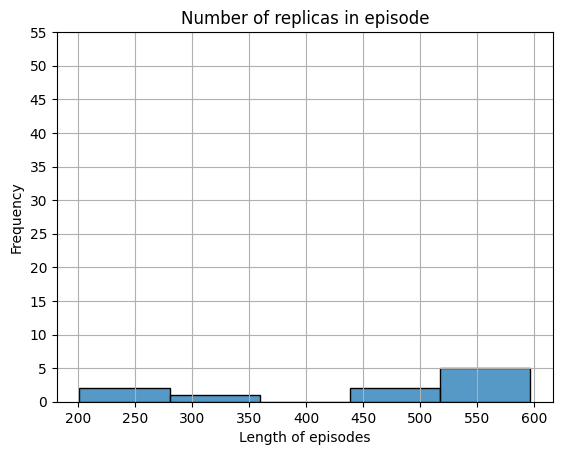

In [ ]:
sns.histplot(episode_length)
plt.xlabel("Length of episodes");
plt.ylabel("Frequency");
plt.title("Number of replicas in episode");
plt.yticks(np.arange(0,60,5));
plt.grid(True)

In [ ]:
mean = np.array(episode_length).mean()
std = np.array(episode_length).std()
mean, std

(454.1, 138.40046965238233)

Mean length of the episode is 250 sentences or replicas. But there were episodes where characters said more then 400 replicas

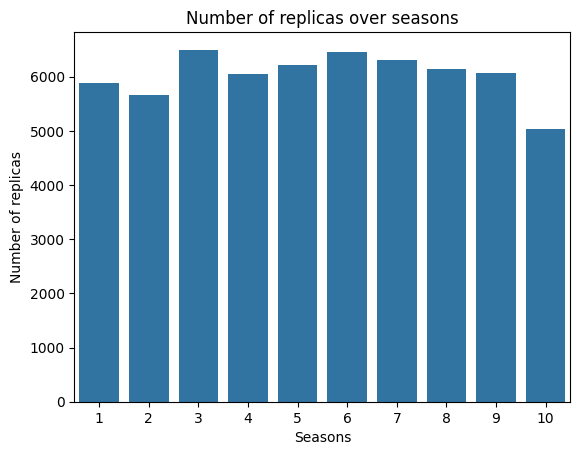

In [ ]:
sns.barplot(season_length)
plt.xlabel("Seasons");
plt.ylabel("Number of replicas");
plt.title("Number of replicas over seasons");

In [ ]:
season_length_list = np.array([v for k,v in season_length.items()])
mean = season_length_list.mean()
std = season_length_list.std()
print(mean, std)

6034.7 408.36039230072254


In [ ]:
scripts_by_character = { name : '' for name in main_characters}
num_scripts_by_character = { name : 0 for name in main_characters}

for season in tqdm(scripts_with_context):
    for episode in scripts_with_context[season]:
        episode_script = scripts_with_context[season][episode].split(NEWLINE_REPLACEMENT)
        for line in episode_script:
            column_loc = line.find(':')
            character = line[:column_loc]
            if character in main_characters:
                scripts_by_character[character] += line[column_loc + 1:].strip().replace('&#39;','') + ' '
                num_scripts_by_character[character] += 1

100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


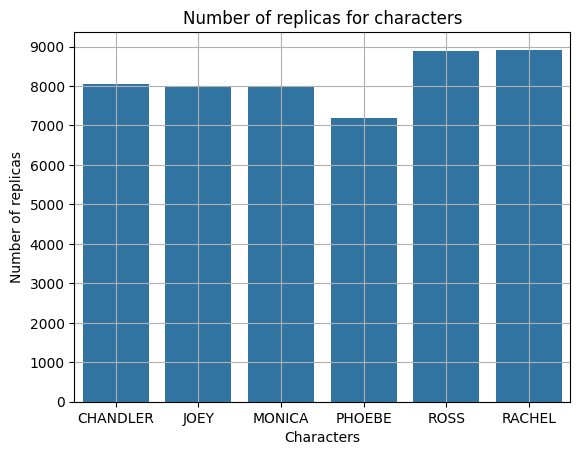

In [ ]:
sns.barplot(num_scripts_by_character)
plt.xlabel("Characters");
plt.ylabel("Number of replicas");
plt.title("Number of replicas for characters");
plt.yticks(np.arange(0, 10000, 1000))
plt.grid(True)

Chech number of replicas with pandas

In [ ]:
df["Characters"].value_counts()

OTHER       11349
RACHEL       8920
ROSS         8885
CHANDLER     8063
JOEY         7989
MONICA       7963
PHOEBE       7178
Name: Characters, dtype: int64

# Text analysis

In [ ]:
!pip install pyLDAvis -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 26.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.21.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


In [ ]:
import string
import re
from pprint import pprint

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk
from nltk import pos_tag
from nltk.stem import wordnet
from nltk.corpus import stopwords
nltk.download('omw-1.4')  #this is for the .apply() function to work
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Write text for every character

In [ ]:
for character, lines in scripts_by_character.items():
    with open(f'english/{character}.txt', "w") as text_file:
        text_file.write(lines)

Make text anslysis for Rachel Green

In [ ]:
with open("./english/RACHEL.txt", "r") as f:
    text = f.readlines()[0]
text

'Oh God Monica hi! I just went to your building and you weren\'t there and then this guy with a big hammer said you might be here and you are, you are! Hi, sure! Oh God... well, it started about a half hour before the wedding. I was in the room where we were keeping all the presents, and I was looking at this gravy boat. This really gorgeous Lamauge gravy boat. When all of a sudden- Sweet \'n\' Lo?- I realised that I was more turned on by this gravy boat than by Barry! And then I got really freaked out, and that\'s when it hit me: how much Barry looks like Mr. Potato Head. Y\'know, I mean, he always looked familiar, but... Anyway, I just had to get out of there, and I started wondering \'Why am I doing this, and who am I doing this for?\'. So anyway I just didn\'t know where to go, and I know that you and I have kinda drifted apart, but you\'re the only person I knew who lived here in the city. Ooh, I was kinda hoping that wouldn\'t be an issue... Daddy, I just... I can\'t marry him! I

In [ ]:
stop = stopwords.words('english')
def text_normalization(text):
    text = str(text).lower()  # convert to all lower letters
    spl_char_text = re.sub(r'[^a-z]', ' ', text)  # remove any special characters including numbers
    tokens = nltk.word_tokenize(spl_char_text)  # tokenize words
    lema = wordnet.WordNetLemmatizer()  # lemmatizer initiation
    tags_list = pos_tag(tokens, tagset = None)  # parts of speech
    lema_words = []
    for token, pos_token in tags_list:
        if pos_token.startswith('V'):  # if the tag from tag_list is a verb, assign 'v' to it's pos_val
            pos_val = 'v'
        elif pos_token.startswith('J'):  # adjective
            pos_val = 'a'
        elif pos_token.startswith('R'):  # adverb
            pos_val = 'r'
        else:  # otherwise it must be a noun
            pos_val = 'n'
        lema_token = lema.lemmatize(token, pos_val)  # performing lemmatization
        lema_words.append(lema_token)  # addid the lemmatized words into our list

    lema_words = [word for word in lema_words if word not in stop]

    # return " ".join(lema_words)  # return our list as a human sentence
    return lema_words

In [ ]:
tokenized_word = nltk.word_tokenize(text)
print(tokenized_word)

['Oh', 'God', 'Monica', 'hi', '!', 'I', 'just', 'went', 'to', 'your', 'building', 'and', 'you', 'were', "n't", 'there', 'and', 'then', 'this', 'guy', 'with', 'a', 'big', 'hammer', 'said', 'you', 'might', 'be', 'here', 'and', 'you', 'are', ',', 'you', 'are', '!', 'Hi', ',', 'sure', '!', 'Oh', 'God', '...', 'well', ',', 'it', 'started', 'about', 'a', 'half', 'hour', 'before', 'the', 'wedding', '.', 'I', 'was', 'in', 'the', 'room', 'where', 'we', 'were', 'keeping', 'all', 'the', 'presents', ',', 'and', 'I', 'was', 'looking', 'at', 'this', 'gravy', 'boat', '.', 'This', 'really', 'gorgeous', 'Lamauge', 'gravy', 'boat', '.', 'When', 'all', 'of', 'a', 'sudden-', 'Sweet', "'n", "'", 'Lo', '?', '-', 'I', 'realised', 'that', 'I', 'was', 'more', 'turned', 'on', 'by', 'this', 'gravy', 'boat', 'than', 'by', 'Barry', '!', 'And', 'then', 'I', 'got', 'really', 'freaked', 'out', ',', 'and', 'that', "'s", 'when', 'it', 'hit', 'me', ':', 'how', 'much', 'Barry', 'looks', 'like', 'Mr', '.', 'Potato', 'Head

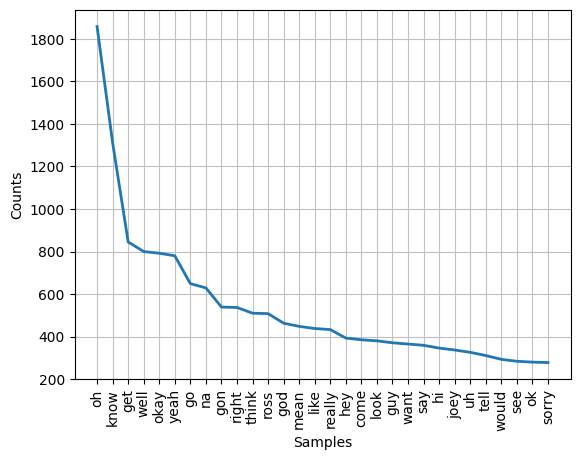

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
preprocessed_text = text_normalization(text)
fdist = nltk.probability.FreqDist(preprocessed_text)
# Frequency Distribution Plot
fdist.plot(30,cumulative=False)

## Statistics

In [ ]:
# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import codecs

import pandas as pd
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

Most frequent words in dataset, without stopwords



In [ ]:
all_words = df['Texts'].str.split(expand=True).stack().value_counts()

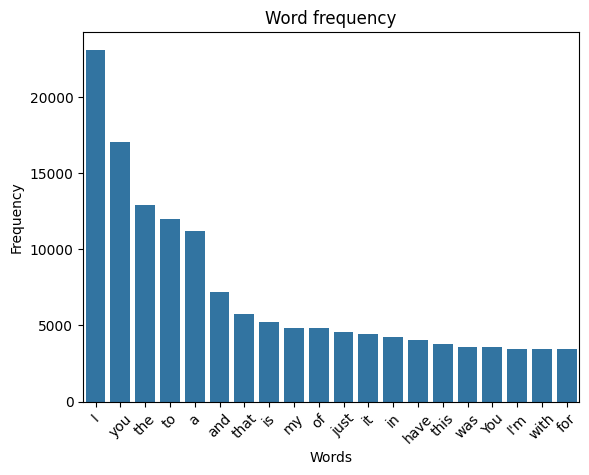

In [ ]:
sns.barplot(all_words[:20]);
plt.xticks(rotation=45);
plt.title("Word frequency");
plt.xlabel("Words");
plt.ylabel("Frequency");

Creat wordcloud with Rachel's word

In [ ]:
rachel = df[df.Characters=="RACHEL"]["Texts"].values
rachel[:2]

array(["Oh God Monica hi! I just went to your building and you weren't there and then this guy with a big hammer said you might be here and you are, you are!",
       'Hi, sure!'], dtype=object)

In [ ]:
img1 = plt.imread("/content/style_transfer_sirius2021summer/data/bigram_pics/rachel.jpg")
hcmask_rachel = img1

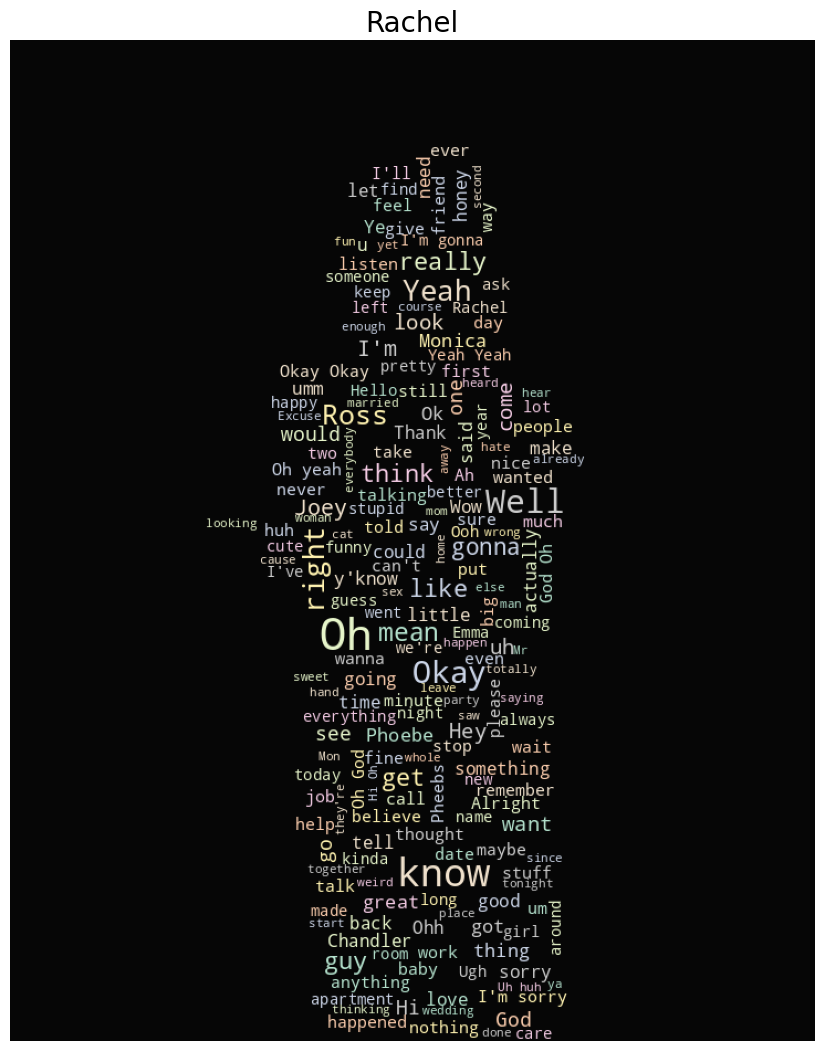

In [ ]:
plt.figure(figsize=(16,13));
wc = WordCloud(background_color="black", max_words=199,
               mask=hcmask_rachel, stopwords=stop, max_font_size=40);
wc.generate(" ".join(rachel));
plt.title("Rachel", fontsize=20);
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98);
plt.axis('off');

Preprocess every text in dataset

In [ ]:
def text_normalization_v2(text):
    text = str(text).lower()  # convert to all lower letters
    spl_char_text = re.sub(r'[^a-z]', ' ', text)  # remove any special characters including numbers
    tokens = nltk.word_tokenize(spl_char_text)  # tokenize words
    lema = wordnet.WordNetLemmatizer()  # lemmatizer initiation
    tags_list = pos_tag(tokens, tagset = None)  # parts of speech
    lema_words = []
    for token, pos_token in tags_list:
        if pos_token.startswith('V'):  # if the tag from tag_list is a verb, assign 'v' to it's pos_val
            pos_val = 'v'
        elif pos_token.startswith('J'):  # adjective
            pos_val = 'a'
        elif pos_token.startswith('R'):  # adverb
            pos_val = 'r'
        else:  # otherwise it must be a noun
            pos_val = 'n'
        lema_token = lema.lemmatize(token, pos_val)  # performing lemmatization
        lema_words.append(lema_token)  # addid the lemmatized words into our list

    lema_words = [word for word in lema_words if word not in stop]

    return " ".join(lema_words)  # return our list as a human sentence
    # return lema_words

In [ ]:
df_text = df['Texts'].apply(text_normalization_v2)

Implement TF-IDF

In [ ]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, decode_error="ignore")
x_tfidf = tfidf.fit_transform(df_text)
feature_names = tfidf.get_feature_names_out()

In [ ]:
count_vec = np.asarray(x_tfidf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))

Text(0.5, 1.0, 'Bottom 15 Words')

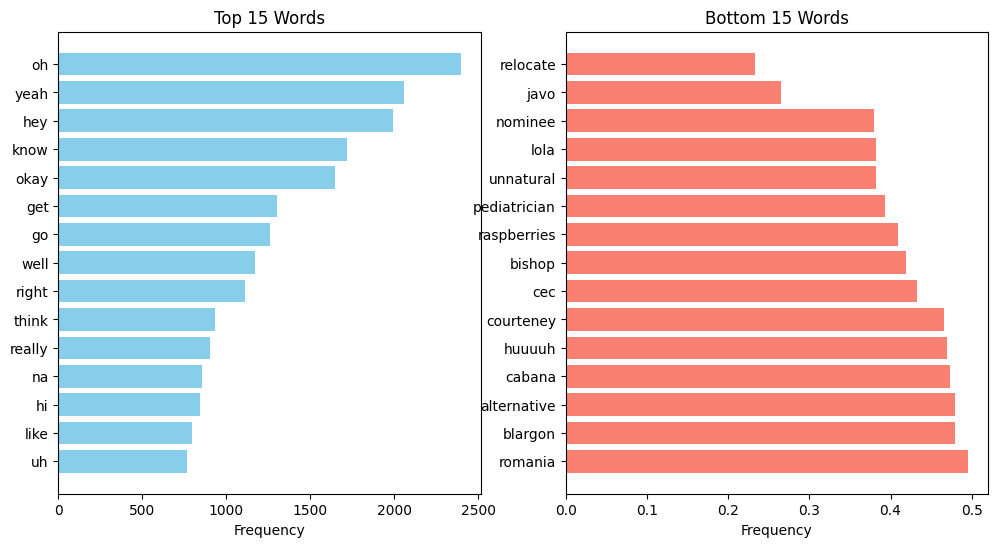

In [ ]:
# Extract top 15 and bottom 15 words
top_words = list(zip(*sorted(zipped, key=lambda x: x[1], reverse=True)[:15]))
bottom_words = list(zip(*sorted(zipped, key=lambda x: x[1])[:15]))

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Top words
axes[0].barh(range(len(top_words[0])), top_words[1], align='center', color='skyblue')
axes[0].set_yticks(range(len(top_words[0])))
axes[0].set_yticklabels(top_words[0])
axes[0].invert_yaxis()  # Invert y-axis to have the most frequent words at the top
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 15 Words')

# Bottom words
axes[1].barh(range(len(bottom_words[0])), bottom_words[1], align='center', color='salmon')
axes[1].set_yticks(range(len(bottom_words[0])))
axes[1].set_yticklabels(bottom_words[0])
axes[1].invert_yaxis()  # Invert y-axis to have the least frequent words at the top
axes[1].set_xlabel('Frequency')
axes[1].set_title('Bottom 15 Words')

In [ ]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [ ]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)
lda.fit(x_tfidf)
n_top_words = 40
print("\nTopics in LDA model: ")
feature_names = tfidf.get_feature_names_out()
print_top_words(lda, feature_names, n_top_words)


Topics in LDA model: 

Topic #0:see ohh like ready hear ya best sleep someone woman beautiful house place sound party oh around throw dog welcome bing different bet get ow hair surprise set feeling doin know guy goodbye look kick okay top suck small porn

Topic #1:really right huh nice want mean look girl try last call miss night problem weird show turn think know sit well find must phone picture ring like promise propose smell get car great oh yay touch tape might emily say

Topic #2:yeah oh god thank come much fun give pretty break good watch know cool name hard couple mr week already ha geller married ticket freak damn half without hat hour buy catch nobody husband daddy actor front heart think well

Topic #3:think get ok love baby tell one bye know still thing take would well go marry wrong oh care way ta emma want yeah right matter course ever home guy dude meet mean kind see something mon look like worry

Topic #4:sure say good rach please bad hello win know get oh year honey lo

In [ ]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [ ]:
first_topic_words = [feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

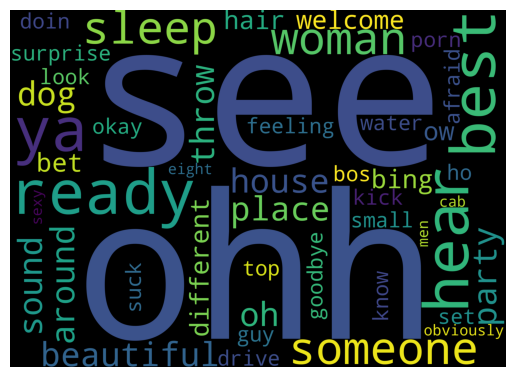

In [ ]:
# Generating the wordcloud with the values under the category dataframe
firstcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

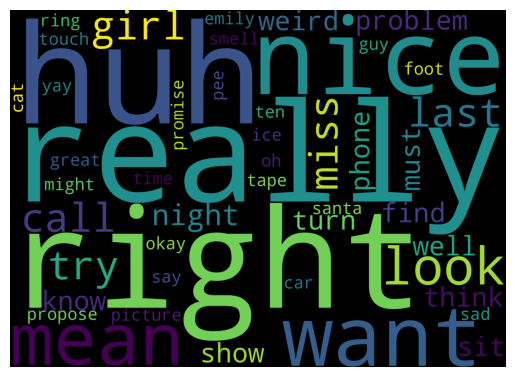

In [ ]:
# Generating the wordcloud with the values under the category dataframe
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [ ]:
rachel_df = df[df.Characters == 'RACHEL']
rachel_text = rachel_df['Texts'].apply(text_normalization_v2)


tfidf_rachel = TfidfVectorizer(max_df=0.95,
                               min_df=2,
                               decode_error="ignore",
                               stop_words=stop)

tf_rachel = tfidf_rachel.fit_transform(rachel_text)
feature_names_rachel = tfidf_rachel.get_feature_names_out()

lda_rachel = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

lda_rachel.fit(tf_rachel)
n_top_words = 40
print("\nTopics in LDA model: ")
print_top_words(lda_rachel, feature_names_rachel, n_top_words)


Topics in LDA model: 

Topic #0:yes uh get huh never hear like believe crazy oh bad know hell try man table message hard around emily coffee fire work bitch enough turn anybody damn married well news game old eh buck coat important drake interested middle

Topic #1:right good say chandler anything watch honey aw must oh wonderful joey different play daddy always nobody mean know propose like hold kick dina relax fall invite worth carol swear would asleep dead fact awww across well drunk thing spider

Topic #2:sorry wow phoebe come oh emma please ask want look umm bye hello ah sweet cute sleep seriously know well sit guess bring serious else see guy somebody change yet chair someone get gavin doctor huge drop exactly honey ridiculous

Topic #3:hi go fine ooh happen oh ow remember late course guy pretty almost help bag cool come sweetie high lose unbelievable joey face tag dollar fault barry straight office school dream well free assistant joanna kind hundred hit tape uncle

Topic #4:lo

In [ ]:
import nltk
from nltk.collocations import *
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import Counter

import base64
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# import pymorphy2
from tqdm import tqdm
import copy
import os
import random

Clean english dialogs

In [ ]:
repeat_phr_en = [('(hey )+', 'hey '),
                ('(whoa )+', 'whoa '),
                ('(yeah )+', 'yeah '),
                ('(wait )+', 'wait '),
                ('(la )+', 'la '),
                ('(ha )+', 'ha '),
                ('(ho )+', 'ho '),
                ('(oh )+', 'oh '),
                ('(bye )+', 'bye '),
                ('(kitty )+', 'kitty '),
                ('(ow )+', 'ow '),
                ('(ooh )+', 'ooh '),
                ('(woo )+', 'woo '),
                ('(woah )+', 'woah '),
                ('(uh )+', 'uh '),
                ('(listen )+', 'listen '),
                ('(blur )+', 'blur '),
                ('(ross )+', 'ross '),
                ('(blah )+', 'blah '),
                ('(hur )+', 'hur '),
                ('(alright )+', 'alright '),
                ('(monica )+', 'monica '),
                ('(quack )+', 'quack '),
                ('(whoo )+', 'whoo '),
                ('(good game )+', 'good game '),
                ('(whoo )+', 'whoo '),
                ('(ew )+', 'ew '),
                ('(yep )+', 'yep '),
                ('(wha wh )+', 'wha wh '),
                ('(baby ooh )+', 'baby ooh '),
                ('(mon )+', 'mon '),
                ('(bing )+', 'bing '),
                ('(coke diet )+', 'coke diet '),
                ('(diet coke )+', 'diet coke '),
                ('(ooh baby baby )+', 'ooh baby baby '),
                ('(good )+', 'good '),
                ('(mee )+', 'mee '),
                ('(ar )+', 'ar '),
                ('(shoop )+', 'shoop '),
                ('(sick )+', 'sick '),
                ('(damnit )+', 'damnit '),
                ('(smelly cat )+', 'smelly cat '),
                ('(tweet )+', 'tweet'),
                ('(quack )+', 'quack'),
                ('(ye )+', 'ye '),
                ('(good luck )+', 'good luck ')
                ]

def delete_rep_en(text):
    for ban, bantr in repeat_phr_en:
        text = re.sub(ban, bantr, text)
    return text

In [ ]:
scripts_with_context_new = scripts_with_context

In [ ]:
scripts_with_context_new[1].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [ ]:
for season in scripts_with_context_new.keys():
    for episode in scripts_with_context_new[season].keys():
      text = scripts_with_context_new[season][episode]
      scripts_with_context_new[season][episode] = text.replace(NEWLINE_REPLACEMENT, '\n')

In [ ]:
# выгружаем все реплики персонажей
script_by_character_new = {character : [] for character in main_characters}
script_by_character_new['OTHER'] = []

prev_char = 'OTHER'
prev_repl = ''

for season, script in scripts_with_context_new.items():
    for episode, lines in script.items():
        for el in lines.split("\n"):
            tag = el.find(':')
            if tag > -1:
                prev_char  = el[:tag]
                if el[tag+2:] != "" and prev_char in script_by_character_new:
                    script_by_character_new[prev_char].append(el[tag+2:])

for character, script in script_by_character_new.items():
    with open(f'{character}.txt', "w", encoding="utf-8") as f:
        f.write(" ".join(script))

Create monologues for training

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
import random

In [ ]:
main_characters = ['CHANDLER', 'JOEY', 'MONICA', 'PHOEBE', 'ROSS', 'RACHEL']
mono_by_character = { character : [] for character in main_characters }

for ch in tqdm(main_characters):
    with open(f"/content/english/{ch}.txt") as replics:
        text = replics.read()
        for r in sent_tokenize(text):
          if len(r) > 2:
            mono_by_character[ch].append(f'<s>{ch}: {r}</s>')

100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


Write files

In [ ]:
for ch in mono_by_character:
    res_list = mono_by_character[ch]
    random.shuffle(res_list)
    with open(f"/content/english/{ch}_mono_train_9to1.txt", "w", encoding='utf-8') as text_file:
        text_file.write('\n'.join(res_list[:int(len(res_list)*0.9)]))
    with open(f"/content/english/{ch}_mono_valid_9to1.txt", "w", encoding='utf-8') as text_file:
        text_file.write('\n'.join(res_list[int(len(res_list)*0.9):]))

Prepare replics

In [ ]:
# приводим к виду
# <s>НЕДРУГ: ...
# герой: ...</s>

main_characters = ['CHANDLER', 'JOEY', 'MONICA', 'PHOEBE', 'ROSS', 'RACHEL']

script_by_character = { character : [] for character in main_characters }
script_by_character['OTHER'] = []

prev_char = 'OTHER'
prev_repl = ''

st = [",", ".", "'", "!", '"', "#", "$", "%", "&", "(", ")", "*", "+", "-", ".", "/", ":", ";", "<", "=", '>', "?",
      "@", "[", "\\", "]", "^", "_", '`', "{", "|", "}", '~', '\t', '\n']

for season in tqdm(scripts_with_context.keys(), desc='SEASON: '):
    for serie in tqdm(scripts_with_context[season], desc='\tEPISODE: '):
      with open(f'english/{season}/{episode}.txt', "r") as text_file:
        line = text_file.readlines()

        for el in line:
            try:
                script_by_character[el[:el.find(':')]].append(f'<s>OTHER: {prev_repl}\n{el.strip()}</s>')
                prev_char  = el[:el.find(':')]
                prev_repl = el[el.find(':')+2:].strip()
            except:
                print(f"season:{season} -> episode{episode}")
                print(el)
                print()
        else:
            continue

for ch in script_by_character:
    random.shuffle(script_by_character[ch])
    with open(f"/content/english/{ch}_train_9to1_long.txt", "w", encoding='utf-8') as text_file:
        text_file.write('\n'.join(script_by_character[ch][:int(len(script_by_character[ch])*0.9)]))
    with open(f"/content/english/{ch}_valid_9to1_long.txt", "w", encoding='utf-8') as text_file:
        text_file.write('\n'.join(script_by_character[ch][int(len(script_by_character[ch])*0.9):]))

	EPISODE: 100%|██████████| 24/24 [00:00<00:00, 1418.79it/s]

	EPISODE: 100%|██████████| 23/23 [00:00<00:00, 1436.47it/s]

	EPISODE: 100%|██████████| 25/25 [00:00<00:00, 1210.92it/s]

	EPISODE: 100%|██████████| 23/23 [00:00<00:00, 1249.58it/s]

	EPISODE: 100%|██████████| 23/23 [00:00<00:00, 917.35it/s]

	EPISODE: 100%|██████████| 23/23 [00:00<00:00, 1328.44it/s]

	EPISODE: 100%|██████████| 23/23 [00:00<00:00, 848.75it/s]

SEASON: 100%|██████████| 10/10 [00:00<00:00, 32.16it/s]
